# Mars Express Power Challenge

https://kelvins.esa.int/mars-express-power-challenge/

> The **Mars Express Power Challenge** focuses on the difficult problem of predicting the thermal power consumption. Three full Martian years of [Mars Express](https://en.wikipedia.org/wiki/Mars_Express) telemetry are made available and you are challenged to predict the thermal subsystem power consumption on the following Martian year.


<br>Luís F. Simões
<br>(Kelvins username: `luis`)
<br>{ [LinkedIn](https://nl.linkedin.com/in/lfsimoes), [ResearchGate](https://www.researchgate.net/profile/Luis_Simes), [twitter](https://twitter.com/lfsim), [github](https://github.com/lfsimoes) }

2016-07-31

---
<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

----

In [2]:
import numpy as np

In [3]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['savefig.dpi'] = 100

import seaborn as sns

In [4]:
import pandas as pd

In [5]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [6]:
from tqdm import tqdm, trange
import sys

In [7]:
from echo_state_networks import *

---

# Data loading & preparation

The credit for most of the code in this section goes to Alexander Bauer, who very kindly released a baseline script for the competition on github:

* https://github.com/alex-bauer/kelvin-power-challenge
* [Kelvins - Discussions / Tutorial: SAAF+LTDATA Random Forest baseline script (0.12 PLB)](https://kelvins.esa.int/mars-express-power-challenge/discussion/56/)

Specifically, it includes the code from his [rf_baseline.py](https://github.com/alex-bauer/kelvin-power-challenge/blob/master/src/rf_baseline.py) file.


The sections [Adding DMOP files](#Adding-DMOP-files) and [Adding FTL files](#Adding-FTL-files) (and all blunders they may contain) however, were added by me.

In [8]:
path_to_data = 'data'

In [9]:
# Function to convert the utc timestamp to datetime
def convert_time(df):
    df['ut_ms'] = pd.to_datetime(df['ut_ms'], unit='ms')
    return df

In [10]:
# Function to resample the dataframe to hourly mean
def resample_1H(df):
    df = df.set_index('ut_ms')
    df = df.resample('1H').mean()
    return df

In [11]:
# Function to read a csv file and resample to hourly consumption
def parse_ts(filename, dropna=True):
    df = pd.read_csv(path_to_data + '/' + filename)
    df = convert_time(df)
    df = resample_1H(df)
    if dropna:
        df = df.dropna()
    return df

In [12]:
# Function to read the ltdata files
def parse_ltdata(filename):
    df = pd.read_csv(path_to_data + '/' + filename)
    df = convert_time(df)
    df = df.set_index('ut_ms')
    return df

In [14]:
##Load the power files
pow_train1 = parse_ts('/train_set/power--2008-08-22_2010-07-10.csv')
pow_train2 = parse_ts('/train_set/power--2010-07-10_2012-05-27.csv')
pow_train3 = parse_ts('/train_set/power--2012-05-27_2014-04-14.csv')
# Load the test sample submission file as template for prediction
pow_test = parse_ts('power-prediction-sample-2014-04-14_2016-03-01.csv', False)
# Concatenate the files
power_all = pd.concat([pow_train1, pow_train2, pow_train3, pow_test])

In [15]:
# Same for the saaf files
saaf_train1 = parse_ts('/train_set/context--2008-08-22_2010-07-10--saaf.csv')
saaf_train2 = parse_ts('/train_set/context--2010-07-10_2012-05-27--saaf.csv')
saaf_train3 = parse_ts('/train_set/context--2012-05-27_2014-04-14--saaf.csv')
saaf_test = parse_ts('/test_set/context--2014-04-14_2016-03-01--saaf.csv')
saaf_all = pd.concat([saaf_train1, saaf_train2, saaf_train3, saaf_test])

In [16]:
# Load the ltdata files
ltdata_train1 = parse_ltdata('/train_set/context--2008-08-22_2010-07-10--ltdata.csv')
ltdata_train2 = parse_ltdata('/train_set/context--2010-07-10_2012-05-27--ltdata.csv')
ltdata_train3 = parse_ltdata('/train_set/context--2012-05-27_2014-04-14--ltdata.csv')
ltdata_test = parse_ltdata('/test_set/context--2014-04-14_2016-03-01--ltdata.csv')
ltdata_all = pd.concat([ltdata_train1, ltdata_train2, ltdata_train3, ltdata_test])

In [17]:
# Extract the columns that need to be predicted
power_cols = list(power_all.columns)
print(power_cols)

['NPWD2372', 'NPWD2401', 'NPWD2402', 'NPWD2451', 'NPWD2471', 'NPWD2472', 'NPWD2481', 'NPWD2482', 'NPWD2491', 'NPWD2501', 'NPWD2531', 'NPWD2532', 'NPWD2551', 'NPWD2552', 'NPWD2561', 'NPWD2562', 'NPWD2691', 'NPWD2692', 'NPWD2721', 'NPWD2722', 'NPWD2742', 'NPWD2771', 'NPWD2791', 'NPWD2792', 'NPWD2801', 'NPWD2802', 'NPWD2821', 'NPWD2851', 'NPWD2852', 'NPWD2871', 'NPWD2872', 'NPWD2881', 'NPWD2882']


In [18]:
# Now let's join everything together
df = power_all

In [19]:
# Make sure that saaf has the same sampling as the power, fill gaps with nearest value
saaf_all = saaf_all.reindex(df.index, method='nearest')
ltdata_all = ltdata_all.reindex(df.index, method='nearest')

df = df.join(saaf_all)
df = df.join(ltdata_all)

In [20]:
saaf_all.shape, ltdata_all.shape

((65613, 4), (65613, 6))

In [21]:
df.shape

(65613, 43)

In [22]:
#df

---

### Adding DMOP files

In [23]:
def parse_dmop(filename):
    df = pd.read_csv(path_to_data + '/' + filename)
    df = convert_time(df)

    subsystems = sorted({s[1:4] for s in df['subsystem'] if s[0] == 'A'})
    
    df_expansion = [
        [when] + [(1 if cmd[1:4]==syst else 0) for syst in subsystems]
        for (when, cmd) in df.values
        if cmd[0]=='A']
    
    df = pd.DataFrame(df_expansion, columns=['ut_ms'] + subsystems)
    df = df.set_index('ut_ms')
    
    # get one row per hour, containing the boolean values indicating whether each
    # subsystem was activated in that hour;
    # hours not represented in the file have all columns with 0.
#    df = df.resample('1H').max().fillna(0)
    # cells represent number of times intructions were issued to that subsystem in that hour
    df = df.resample('1H').sum().fillna(0)
    
    return df

In [24]:
# Load the dmop files
dmop_train1 = parse_dmop('/train_set/context--2008-08-22_2010-07-10--dmop.csv')
dmop_train2 = parse_dmop('/train_set/context--2010-07-10_2012-05-27--dmop.csv')
dmop_train3 = parse_dmop('/train_set/context--2012-05-27_2014-04-14--dmop.csv')
dmop_test = parse_dmop('/test_set/context--2014-04-14_2016-03-01--dmop.csv')
dmop_all = pd.concat([dmop_train1, dmop_train2, dmop_train3, dmop_test]).fillna(0)

In [25]:
#dmop_all

In [26]:
dmop_all.describe()

,AAA,ACF,DMC,DMF,HHH,MMM,OOO,PSF,PWF,SEQ,SSS,SXX,TMB,TTT,VVV,XXX
count,65618.000000,65618.000000,65618.000000,65618.000000,65618.000000,65618.00000,65618.000000,65618.000000,65618.000000,65618.000000,65618.000000,65618.000000,65618.000000,65618.000000,65618.000000,65618.000000
mean,1.864046,1.974519,0.010500,0.009967,0.365525,1.23425,0.310662,1.571429,0.030403,0.028514,0.380368,0.076199,0.059770,0.645006,0.333003,0.099333
std,5.741605,3.505698,0.132257,0.117730,1.916104,2.81427,1.318932,5.033112,0.186910,0.181671,0.972357,0.359853,0.237127,0.909760,5.024703,0.357037
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,96.000000,22.000000,4.000000,2.000000,58.000000,20.00000,14.000000,58.000000,3.000000,2.000000,12.000000,3.000000,2.000000,10.000000,164.000000,4.000000


In [27]:
dmop_all = dmop_all.reindex(df.index).fillna(0)
df = df.join(dmop_all)

In [28]:
dmop_all.shape

(65613, 16)

In [29]:
df.shape

(65613, 59)

---

### Adding FTL files

In [30]:
from pandas.tslib import Timestamp

def parse_ftl(filename):
    df = pd.read_csv(path_to_data + '/' + filename)
    df['utb_ms'] = pd.to_datetime(df['utb_ms'], unit='ms')
    df['ute_ms'] = pd.to_datetime(df['ute_ms'], unit='ms')
    return df

def parse_ftl_all(filenames, hour_indices):
    ftl_all = pd.concat([parse_ftl(f) for f in filenames])
    
    types = sorted(set(ftl_all['type']))
    ftl_df = pd.DataFrame(index=hour_indices, columns=['flagcomms'] + types).fillna(0)
    
    # hour indices of discarded events, because of non-ocurrence in `hour_indices`
    ix_err = []

    for (t_start, t_end, p_type, comms) in ftl_all.values:
        floor_beg = Timestamp(t_start).floor('1h')
        floor_end = Timestamp(t_end).floor('1h')
        
        try:
            ftl_df.loc[floor_beg]['flagcomms'] = ftl_df.loc[floor_end]['flagcomms'] = int(comms)
            ftl_df.loc[floor_beg][p_type]      = ftl_df.loc[floor_end][p_type]      = 1
        except KeyError:
            ix_err.append((floor_beg, floor_end))
    
    print('Warning: discarded %d FTL events' % len(ix_err))
    
    return ftl_all, ftl_df

In [31]:
ftl_fnames = [
    '/train_set/context--2008-08-22_2010-07-10--ftl.csv',
    '/train_set/context--2010-07-10_2012-05-27--ftl.csv',
    '/train_set/context--2012-05-27_2014-04-14--ftl.csv',
    '/test_set/context--2014-04-14_2016-03-01--ftl.csv',
    ]
%time ftl_all, ftl_df = parse_ftl_all(filenames=ftl_fnames, hour_indices=df.index)

Wall time: 1min 53s


In [32]:
# count number of events per type
#ftl_df.sum(axis=0).sort_values()

# determine which event types occur more than 500 times
min_occ = (ftl_df.sum(axis=0) > 500)

# get their columns names
min_occ_cols = min_occ.index[min_occ.values]
min_occ_cols

# prune out from `ftl_df` the rarely occurring event types
ftl_df_sel = ftl_df[min_occ_cols]

In [33]:
#ftl_df_sel

In [34]:
ftl_df_sel.describe()

,flagcomms,ACROSS_TRACK,D1PVMC,D4PNPO,EARTH,INERTIAL,MAINTENANCE,NADIR,RADIO_SCIENCE,SLEW,WARMUP
count,65613.000000,65613.000000,65613.000000,65613.000000,65613.000000,65613.000000,65613.000000,65613.000000,65613.000000,65613.000000,65613.000000
mean,0.075046,0.028500,0.009465,0.096353,0.421288,0.153750,0.078491,0.060643,0.019798,0.460701,0.037203
std,0.263468,0.166399,0.096825,0.295077,0.493769,0.360712,0.268944,0.238677,0.139306,0.498457,0.189260
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
df = df.join(ftl_df_sel)

In [36]:
ftl_df.shape, ftl_df_sel.shape

((65613, 20), (65613, 11))

In [37]:
df.shape

(65613, 70)

In [38]:
#df

#### FTL data: analysis

Total count on number of times each pointing time occurs in the data

In [39]:
ftl_df.sum(axis=0).sort_values()

D5PPHB               6
D8PLTP              10
SPOT                20
D7PLTS              27
D3POCM              44
NADIR_LANDER        69
SPECULAR            90
D2PLND             209
D9PSPO             260
D1PVMC             621
RADIO_SCIENCE     1299
ACROSS_TRACK      1870
WARMUP            2441
NADIR             3979
flagcomms         4924
MAINTENANCE       5150
D4PNPO            6322
INERTIAL         10088
EARTH            27642
SLEW             30228
dtype: int64

Inspecting the durations of pointing events

In [40]:
t_span = ftl_all['ute_ms'] - ftl_all['utb_ms']
t_span.describe()

count                     66928
mean     0 days 00:59:45.524190
std      0 days 03:25:20.282521
min             0 days 00:00:18
25%             0 days 00:18:40
50%             0 days 00:29:21
75%             0 days 01:10:48
max            32 days 22:00:00
dtype: object

In [41]:
t_span_secs = (t_span.values * 1e-9).astype(np.int)

In [42]:
# number of events lasting more than 2 hours
(t_span_secs > 2*60*60).sum()

7174

In [43]:
_ / len(t_span_secs)

0.10718981592158738

~10% of the pointing events last more than 2h. The longest event lasts 32 days.

---_

** Now we formulate the prediction problem `X -> Y` **
* `Y` is the matrix that we want to predict
* `X` is everything else

In [44]:
Y = df[power_cols]
X = df.drop(power_cols, axis=1)

In [45]:
#X

In [46]:
#Y

In [47]:
#X.describe()

In [48]:
#Y.describe()

In [49]:
# Defining the evaluation metric
def RMSE(val, pred):
    diff = (val - pred) ** 2
    rmse = np.mean(diff.values) ** 0.5
    return rmse

In [50]:
# Splitting the dataset into train and test data
trainset = ~Y[power_cols[0]].isnull()
X_train, Y_train = X[trainset], Y[trainset]
X_test, Y_test = X[~trainset], Y[~trainset]

In [51]:
# Splitting the trainset further for cross-validation
# (trains on two years; leaves the 3rd for validation)
cv_split = X_train.index < '2012-05-27'
X_train_cv, Y_train_cv = X_train[cv_split], Y_train[cv_split]
X_val_cv, Y_val_cv = X_train[~cv_split], Y_train[~cv_split]

In [52]:
X_train_cv.describe()

,sa,sx,sy,sz,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min,...,ACROSS_TRACK,D1PVMC,D4PNPO,EARTH,INERTIAL,MAINTENANCE,NADIR,RADIO_SCIENCE,SLEW,WARMUP
count,32698.000000,32698.000000,32698.000000,32698.000000,3.269800e+04,3.269800e+04,32698.000000,32698.000000,32698.000000,32698.000000,...,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000
mean,5.315321,23.128628,89.947210,106.155617,2.289326e+08,2.656783e+08,22.530150,591.014051,15.083670,16.909974,...,0.038351,0.013701,0.069331,0.468653,0.162273,0.076733,0.092360,0.039727,0.485320,0.062787
std,9.933923,15.337308,7.479340,17.737827,1.505934e+07,9.135108e+07,11.963074,78.707311,19.094363,21.912505,...,0.192045,0.116249,0.254021,0.499024,0.368707,0.266171,0.289538,0.195321,0.499792,0.242583
min,0.000000,0.008333,30.791633,24.863793,2.066449e+08,9.933055e+07,0.306472,492.163272,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.259672,10.704021,89.759579,93.575003,2.139178e+08,1.807494e+08,12.086395,513.557547,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.670000,22.828814,90.020000,106.704021,2.300605e+08,2.963417e+08,23.685294,577.586821,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.156133,31.809393,90.495000,118.984623,2.439811e+08,3.487297e+08,33.970032,668.048126,32.816667,33.016667,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,97.603083,89.844500,138.038868,177.643833,2.492276e+08,3.744911e+08,39.859552,715.899348,55.450000,87.733333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
Y_train_cv.describe()

,NPWD2372,NPWD2401,NPWD2402,NPWD2451,NPWD2471,NPWD2472,NPWD2481,NPWD2482,NPWD2491,NPWD2501,...,NPWD2792,NPWD2801,NPWD2802,NPWD2821,NPWD2851,NPWD2852,NPWD2871,NPWD2872,NPWD2881,NPWD2882
count,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,...,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000,32698.000000
mean,0.124213,0.002112,0.175332,0.669838,0.000739,0.001043,0.001046,0.002432,0.198440,0.005207,...,0.000847,0.001535,0.132893,0.005780,0.261087,0.000528,0.000522,0.000745,0.045851,0.003375
std,0.038342,0.009880,0.001384,0.302857,0.000014,0.000561,0.009234,0.009330,0.045251,0.000089,...,0.000372,0.000029,0.078167,0.000105,0.159312,0.000071,0.000011,0.000014,0.149226,0.000065
min,0.001808,0.001411,0.034283,0.004949,0.000571,0.000613,0.000499,0.001462,0.001962,0.004884,...,0.000545,0.001458,0.002123,0.004438,0.004733,0.000494,0.000479,0.000703,0.006134,0.003156
25%,0.094905,0.001511,0.175089,0.432464,0.000731,0.000646,0.000567,0.001876,0.172507,0.005153,...,0.000576,0.001519,0.069764,0.005724,0.132907,0.000522,0.000516,0.000739,0.006685,0.003343
50%,0.120559,0.001529,0.175343,0.569502,0.000740,0.000656,0.000573,0.001898,0.199225,0.005215,...,0.000586,0.001536,0.132533,0.005793,0.288478,0.000528,0.000523,0.000747,0.006765,0.003383
75%,0.148036,0.001545,0.175606,0.914890,0.000747,0.001590,0.000579,0.001918,0.223866,0.005261,...,0.001204,0.001552,0.182786,0.005844,0.368384,0.000534,0.000528,0.000754,0.006837,0.003416
max,0.376517,0.267175,0.177803,2.175650,0.000857,0.006247,0.364612,0.306428,0.435523,0.006033,...,0.006263,0.001769,0.324555,0.006287,1.146090,0.010409,0.000598,0.000857,0.723399,0.003873


---_

** Here comes the machine learning **

In [54]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=5)
%time rf.fit(X_train_cv, Y_train_cv)
%time Y_val_cv_hat = rf.predict(X_val_cv)

Wall time: 20.2 s
Wall time: 612 ms


Showing the local prediction error and feature importances

In [55]:
rmse = RMSE(Y_val_cv, Y_val_cv_hat)
print("Local prediction error: {}\n".format(rmse))
print("Feature importances:")
for feature, importance in sorted(zip(rf.feature_importances_, X_train.columns), key=lambda x: x[0], reverse=True):
    print(feature, importance)

Local prediction error: 0.1077173101957749

Feature importances:
0.185648214894 earthmars_km
0.167835330728 eclipseduration_min
0.0823167849748 sunmarsearthangle_deg
0.0787662331765 sz
0.0626673989136 solarconstantmars
0.0608768237838 MMM
0.0591179977961 sunmars_km
0.0476997534332 sa
0.0442800808992 sx
0.0388425537447 sy
0.029967524976 SLEW
0.0268833977041 XXX
0.0263006285168 occultationduration_min
0.0130903284382 AAA
0.0117307301919 TTT
0.0110802292169 OOO
0.0105832049663 MAINTENANCE
0.00791964109356 flagcomms
0.00623063865552 WARMUP
0.00546336720592 EARTH
0.00480636544955 PSF
0.003483033246 SXX
0.00290498279977 INERTIAL
0.002763373338 SSS
0.00144543267125 RADIO_SCIENCE
0.00135859494873 VVV
0.00130287136642 SEQ
0.0011245481631 ACF
0.000964844756308 D1PVMC
0.000863705294501 D4PNPO
0.000775590252513 NADIR
0.000518042701408 HHH
0.000250165936581 ACROSS_TRACK
6.27666351851e-05 TMB
4.04116023185e-05 DMC
3.44075289051e-05 PWF
0.0 DMF


In [ ]:
# Now we do the training and prediction for the testset
#%time rf.fit(X_train, Y_train)
#%time Y_test_hat = rf.predict(X_test)

In [ ]:
#Preparing the submission file:

#Converting the prediction matrix to a dataframe
#Y_test_hat = pd.DataFrame(Y_test_hat, index=X_test.index, columns=power_cols)
# We need to convert the parsed datetime back to utc timestamp
#Y_test_hat['ut_ms'] = (Y_test_hat.index.astype(np.int64) * 1e-6).astype(int)
# Writing the submission file as csv
#Y_test_hat[['ut_ms'] + power_cols].to_csv('rf_baseline.csv', index=False)

In [ ]:
# Goto https://kelvins.esa.int/mars-express-power-challenge/ , create an account and submit the file!

----

----

----

# Data preparation (II)

In [56]:
# renaming dataset variables
X_all, y_all = X, Y

** Data Scaling **

scaling of X will use the full set of data (train & test)

In [57]:
_x = X_all.as_matrix()
sc_min = _x.min(axis=0)
sc_max = _x.max(axis=0)
sc_avg = _x.mean(axis=0)
sc_std = _x.std(axis=0)

In [58]:
def scale(X):
    return (X - sc_min) / (sc_max - sc_min)
#    return 2 * (X - sc_min) / (sc_max - sc_min) - 1

def scale2(X):
    return (X - sc_avg) / sc_std

** Aliases: training on `X -> y`, testing on `Xt -> yt` **

In [59]:
X, y = X_train_cv.as_matrix(), Y_train_cv.as_matrix()
Xt, yt = X_val_cv.as_matrix(), Y_val_cv.as_matrix()

In [60]:
X.shape, y.shape

((32698, 37), (32698, 33))

In [61]:
Xt.shape, yt.shape

((16427, 37), (16427, 33))

In [62]:
X_date = X_train_cv.index
Xt_date = X_val_cv.index

** Mean `y` state in the "train_cv" set **

In [63]:
y_mean = y.mean(axis=0)

----

# Auxiliary code

In [66]:
# re-defining the evaluation metric (to work over numpy matrices)
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [67]:
# RMSE per instant (hour) in the dataset
def RMSE_per_instant(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2, axis=1) ** 0.5

In [65]:
def moving_average(a, n=3):
    """
    >>> moving_average(np.arange(10), n=3)
    array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.])
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    # http://stackoverflow.com/a/14314054

In [68]:
from collections import namedtuple
err_range = namedtuple('rmse', ['range', 'period'])


def error_evolution(y_true, y_pred, dates=None):
    # assign each instant the RSME of a 1-month window centered on it
    err_x_t = RMSE_per_instant(y_true=y_true, y_pred=y_pred)
    # number of instants to aggregate (30 days * 24 hours)
    nr_insts_agg = 30 * 24
    rmse_per_month = moving_average(err_x_t ** 2, n=nr_insts_agg) ** 0.5
    
    # these dates may be slightly off, but for plotting purposes they're close enough
    if dates is None:
        rmse_per_month_dates = None
    else:
        h = int(nr_insts_agg / 2)
        rmse_per_month_dates = dates[h : h + len(rmse_per_month)]
    
    # measure RMSE incrementally, up to each of 1000 evenly-spaced
    # instants along the full time span
    rmse_so_far = [
        (i if dates is None else dates[int(i-1)], RMSE(y_true=y_true[:int(i)], y_pred=y_pred[:int(i)]))
        for i in np.linspace(1, len(y_true), 1000)]
    
    return (rmse_per_month_dates, rmse_per_month), rmse_so_far
    

def error_evolution_summary(err_evol):
    (_, rmse_per_month), rmse_so_far = err_evol
    
    per_month = err_range([f(rmse_per_month) for f in [np.min, np.max]], 'per_month')
    so_far = err_range([f(rmse_so_far, key=lambda i:i[1])[1] for f in [min, max]], 'so_far')
    
    return rmse_so_far[-1][1], per_month, so_far

In [69]:
martian_years = [
    year_data.index[0]
    for year_data in [pow_train1, pow_train2, pow_train3, pow_test]
    ] + [pow_test.index[-1]]
martian_years

[Timestamp('2008-08-22 00:00:00'),
 Timestamp('2010-07-10 00:00:00'),
 Timestamp('2012-05-27 00:00:00'),
 Timestamp('2014-04-14 00:00:00', offset='H'),
 Timestamp('2016-02-29 23:00:00', offset='H')]

In [86]:
def show_error_evolution(errors, dataset=''):
    lgd_args = dict(ncol=2, loc='best', frameon=True, fancybox=True)

    def show_martian_years():
        xl = plt.xlim()
        for my in martian_years:
            plt.axvline(my, ls=':', color='grey')
        plt.xlim(xl)
    
    def find_extreme(func, data, cutoff=0.05):
        return func(data[int(cutoff * len(data)):], key=lambda i:i[1])[1]
    
    plt.figure(figsize=(11,5))
    for err_evol, label in errors:
        dates, err = err_evol[0]
        if dates is not None:
            plt.plot(dates, err, label=label)
        else:
            plt.plot(err, label=label)
    plt.legend(**lgd_args)
    plt.xlabel('Date'); plt.ylabel('RMSE')
    t = ((dataset + ' e') if dataset != '' else 'E') + 'rror over a 30-days sliding window'
    plt.title(t)
    show_martian_years()
    fig1 = plt.gcf()
    
    plt.figure(figsize=(11,5))
    for err_evol, label in errors:
        plt.plot(*zip(*err_evol[1]), label=label)
    plt.legend(**lgd_args)
    plt.xlabel('Date'); plt.ylabel('RMSE')
    t = ((dataset + ' e') if dataset != '' else 'E') + 'rror in all predictions up to the current date'
    plt.title(t)
    show_martian_years()
    
    m = 0.95 * min(find_extreme(min, esf) for ((_,esf),_) in errors)
    M = 1.05 * max(find_extreme(max, esf) for ((_,esf),_) in errors)
    plt.ylim(m, M)
    fig2 = plt.gcf()
    
    return fig1, fig2

In [64]:
def initialize_rng(seed=None, seeder_rng=None, *args, **kwargs):
    """
    Initializes a separate numpy random number generator object. Its state
    is initialized using `seed`, if provided, or a newly generated seed if not.

    Should a random number generator function be provided (`seeder_rng`), it
    will be used to generate the seed. Otherwise, `numpy.random.randint` will be
    used as the seeder. Valid functions to provide in `seeder_rng` include
    `random.randrange` and `numpy.random.randint`, or equivalent functions from
    independent generators, given by `random.Random` or `np.random.RandomState`.
    """
    if seed is None:
        random_integer = np.random.randint if seeder_rng is None else seeder_rng
        # np.random.randint converts its arguments internally to C signed longs
        # (32 bits, ranging in [-2**31, 2**31-1])
        lim = 2**31
        seed = random_integer(-lim, lim-1)
        # RandomState requires a seed in [0, 2**32-1]
        seed += lim

    rng = np.random.RandomState(seed)
    return rng, seed

In [71]:
def median_seed(model_class, model_args=None, train_args=None, nr_runs=11):
    """
    Find a random number generator seed that leads a model to
    achieve its estimated median performance.
    """
    # uses globals: X, y, Xt, yt
    
    model_args = {} if model_args is None else model_args
    train_args = {} if train_args is None else train_args
    
    rng, _ = initialize_rng(seed=1)
    rngs, seeds = zip(*[
        initialize_rng(seeder_rng=rng.randint)
        for i in range(nr_runs)
        ])
    
    errs = []
    for r in rngs:
        m = model_class(random_state=r, **model_args)
        m.fit(X, y, **train_args)
        yt_p = m.predict(Xt)
        errs.append(RMSE(y_true=yt, y_pred=yt_p))
    
    return sorted(zip(errs, seeds))[int(nr_runs / 2)]

----

# Reference performance data

Measure the performance obtained by Random Forests, for comparisons in plots shown later on.

The parameter settings below come from Alex's [rf_baseline.py](https://github.com/alex-bauer/kelvin-power-challenge/blob/master/src/rf_baseline.py). For a discusson on their tuning, see [this thread](https://kelvins.esa.int/mars-express-power-challenge/discussion/56/#c81) at the competition's forum.
<br>For additional information, see: [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), 
[ExtraTreesRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html).

In [91]:
model_args = dict(n_estimators=100, n_jobs=-1, min_samples_leaf=5)

In [ ]:
# get a seed that results in a model of median performance; picked: 4290846341
#%time median_seed(RandomForestRegressor, model_args, nr_runs=11)[1]

In [93]:
m = RandomForestRegressor(random_state=np.random.RandomState(seed=4290846341), **model_args)
%time m.fit(X, y)
%time y_p = m.predict(X)
%time yt_p = m.predict(Xt)

Wall time: 17.3 s
Wall time: 988 ms
Wall time: 503 ms


In [94]:
rf_err_evol = error_evolution(y, y_p, X_date)
rf_err_evol_t = error_evolution(yt, yt_p, Xt_date)
# summary of the test set error
error_evolution_summary(rf_err_evol_t)

(0.10708580906484788,
 rmse(range=[0.055854491136136983, 0.15522297102008958], period='per_month'),
 rmse(range=[0.085396353588078872, 0.10770891622510056], period='so_far'))

In [ ]:
# get a seed that results in a model of median performance; picked: 630311759
#%time median_seed(ExtraTreesRegressor, model_args, nr_runs=11)[1]

In [96]:
m = ExtraTreesRegressor(random_state=np.random.RandomState(seed=630311759), **model_args)
%time m.fit(X, y)
%time y_p = m.predict(X)
%time yt_p = m.predict(Xt)

Wall time: 9.23 s
Wall time: 963 ms
Wall time: 493 ms


In [97]:
et_err_evol = error_evolution(y, y_p, X_date)
et_err_evol_t = error_evolution(yt, yt_p, Xt_date)
# summary of the test set error
error_evolution_summary(et_err_evol_t)

(0.10892480576146149,
 rmse(range=[0.053915048347104012, 0.16116252707442466], period='per_month'),
 rmse(range=[0.088380648922985638, 0.12710749650395242], period='so_far'))

Error over the train set

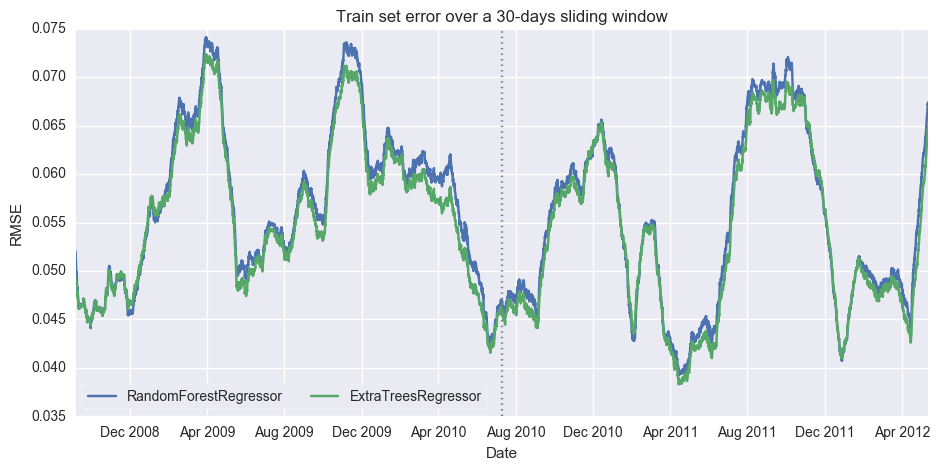

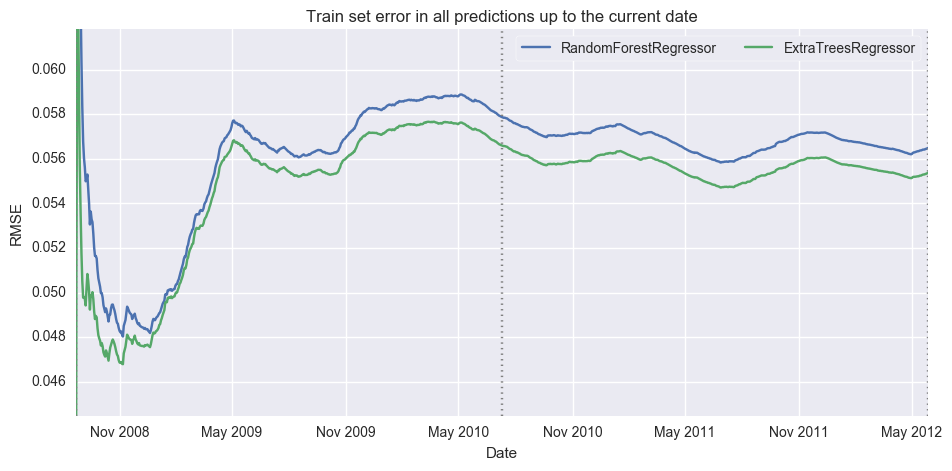

In [98]:
show_error_evolution([
    (rf_err_evol, 'RandomForestRegressor'),
    (et_err_evol, 'ExtraTreesRegressor')
    ], 'Train set');

Error over the test set

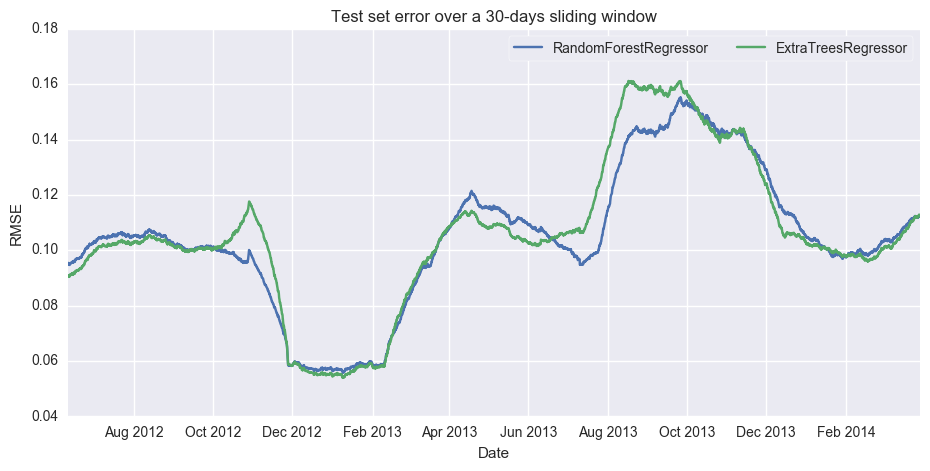

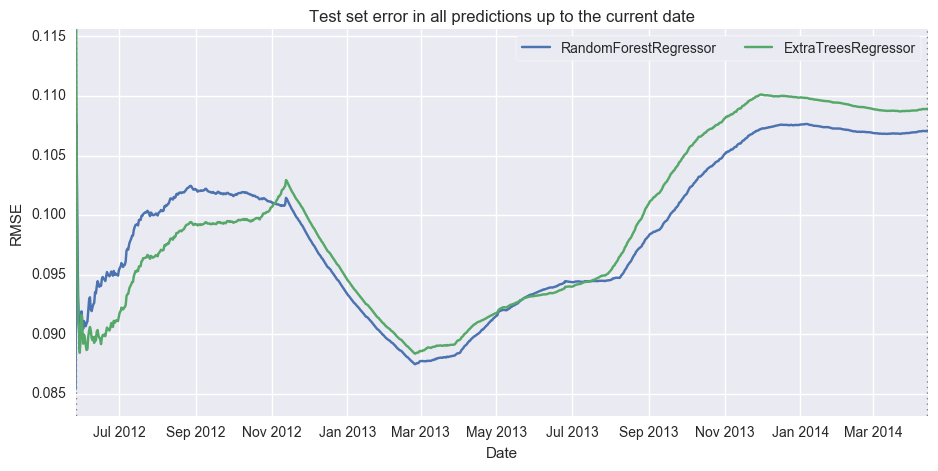

In [99]:
show_error_evolution([
    (rf_err_evol_t, 'RandomForestRegressor'),
    (et_err_evol_t, 'ExtraTreesRegressor')
    ], 'Test set');

---

# Echo State Networks

## Parameter sweep

Tuning parameters for the fitting of single (non-ensembled) ESN models.

In [94]:
def esn_eval_setup(model_args, train_args, nr_runs=50, desc=None):
    """
    Evaluate the performance of ESN models, trained with
    the given parameters, across several runs.
    """
    # uses globals: X, y, Xt, yt
    
    rng, seed = initialize_rng(seed=42)
    res = []
    
    for run in trange(nr_runs, leave=False, file=sys.stdout, desc=desc):
        m = ESN(random_state=rng, **model_args)
        m.fit(scale(X), y, **train_args)
        
        if m.output_feedback:
            yt_p = m.predict(scale(Xt), y_initial=train_args.get('y_initial'))
        else:
            yt_p = m.predict(scale(Xt))
        
        e = RMSE(y_true=yt, y_pred=yt_p)
        res.append(e)
    
    return res

In [87]:
def esn_eval_param(param_name, param_values, model_args, train_args, nr_runs=50):
    "Evaluate alternatives for an ESN parameter"
    model_args = model_args.copy()
    train_args = train_args.copy()
    args = (model_args if param_name in model_args else train_args)
    
    res = {}
    
    for arg in param_values:
        args[param_name] = arg
        res[arg] = esn_eval_setup(model_args, train_args, nr_runs=nr_runs, desc=str(arg))
    
    return res

Below, multiple parameter sweeps are performed, intended to tune parameters one at a time. 
Parameter values aren't however being changed across sub-sections, as they were already previously tuned.

The statistics below are shown to illustrate ESN's sensitivity to different parameter settings. Results are aggregated over 50 independent runs with each setup.

### `nr_neurons`

Number of neurons in the reservoir

In [293]:
model_args = dict(nr_neurons=500, prob_connect=0.25, spectral_radius=0.99, activation='sigmoid', leaking_rate=1,
                  output_feedback=True, y_noise=0.005, alpha=60)
train_args = dict(y_initial=y_mean)

In [294]:
nn_res = esn_eval_param('nr_neurons', [100, 200, 300, 400, 500, 600],
                        model_args, train_args)

In [295]:
{a:np.mean(r) for (a,r) in nn_res.items()}

{100: 0.10550216937933721,
 200: 0.10468455232227868,
 300: 0.10425355750497006,
 400: 0.10331174564256164,
 500: 0.10289282541875558,
 600: 0.10322579490059326}

In [296]:
{a:np.median(r) for (a,r) in nn_res.items()}

{100: 0.1053209804278506,
 200: 0.10486634207153259,
 300: 0.10418986231501565,
 400: 0.10293035599913596,
 500: 0.10267428616294114,
 600: 0.10298447696521341}

### `prob_connect`

Probability of a neuron in the reservoir receiving a recurrrent connection from another reservoir neuron.

In [297]:
model_args = dict(nr_neurons=500, prob_connect=0.25, spectral_radius=0.99, activation='sigmoid', leaking_rate=1,
                  output_feedback=True, y_noise=0.005, alpha=60)
train_args = dict(y_initial=y_mean)

In [298]:
pc_res = esn_eval_param('prob_connect', [0.1, 0.25, 0.5, 0.75, 1.0],
                        model_args, train_args)

In [299]:
{a:np.mean(r) for (a,r) in pc_res.items()}

{0.1: 0.1033439803921066,
 0.25: 0.10289282541875558,
 0.5: 0.10320731084234999,
 0.75: 0.10302575473116439,
 1.0: 0.10312479684950064}

In [300]:
{a:np.median(r) for (a,r) in pc_res.items()}

{0.1: 0.10301561583737742,
 0.25: 0.10267428616294114,
 0.5: 0.10305379351464997,
 0.75: 0.10316140150605105,
 1.0: 0.10320524446355232}

### `spectral_radius`

"The spectral radius of the reservoir weight matrix codetermines (i) the effective time constant of the echo state network (larger spectral radius implies slower decay of impulse response) and (ii) the amount of nonlinear interaction of input components through time (larger spectral radius implies longer-range interactions)."

"[...] it is empirically observed that the *echo state property* (ESP) is granted for any input if this spectral radius is smaller than unity. This has led in the literature to a far-spread but erroneous identification of the ESP with a spectral radius below 1. Specifically, the larger the input amplitude, the further above unity the spectral radius may be while still obtaining the ESP."

-- http://www.scholarpedia.org/article/Echo_state_network

In [304]:
model_args = dict(nr_neurons=500, prob_connect=0.25, spectral_radius=0.99, activation='sigmoid', leaking_rate=1,
                  output_feedback=True, y_noise=0.005, alpha=60)
train_args = dict(y_initial=y_mean)

In [305]:
sr_res = esn_eval_param('spectral_radius', [0.7, 0.8, 0.9, 0.95, 0.99, 2, 3],
                        model_args, train_args)

In [306]:
{a:np.mean(r) for (a,r) in sr_res.items()}

{0.7: 0.10323268059282961,
 0.8: 0.10308331061267108,
 0.9: 0.1029683900537412,
 0.95: 0.10292327574610532,
 0.99: 0.10289282541875558,
 2: 0.10320721712324861,
 3: 0.10404814250660742}

In [307]:
{a:np.median(r) for (a,r) in sr_res.items()}

{0.7: 0.1031278703939548,
 0.8: 0.10296831852038472,
 0.9: 0.10284373518296444,
 0.95: 0.10275924494980786,
 0.99: 0.10267428616294114,
 2: 0.10281221624853926,
 3: 0.10352092265471538}

### `alpha`

Regularization term used in the [Tikhonov regularization / Ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization) of the readout's weights.

In [88]:
model_args = dict(nr_neurons=500, prob_connect=0.25, spectral_radius=0.99, activation='sigmoid', leaking_rate=1,
                  output_feedback=True, y_noise=0.005, alpha=60)
train_args = dict(y_initial=y_mean)

In [89]:
ap_res = esn_eval_param('alpha', [1e-9, 1, 10, 25, 50, 60, 70, 80],
                        model_args, train_args)

In [90]:
{a:np.mean(r) for (a,r) in ap_res.items()}

{1e-09: 0.15729337091939621,
 1: 0.12145942786109738,
 10: 0.10711544956499873,
 25: 0.10411642049426657,
 50: 0.10300208316566105,
 60: 0.10289282541875558,
 70: 0.10284599299171925,
 80: 0.10283531835740777}

In [91]:
{a:np.median(r) for (a,r) in ap_res.items()}

{1e-09: 0.11652029071048131,
 1: 0.10845790699452293,
 10: 0.10484425824140492,
 25: 0.10322936773625711,
 50: 0.10279220231584996,
 60: 0.10267428616294109,
 70: 0.1026968398464933,
 80: 0.10275146256353888}

### `output_feedback`

Indication of whether to feed the readout's predictions back into the reservoir.

In [95]:
model_args = dict(nr_neurons=500, prob_connect=0.25, spectral_radius=0.99, activation='sigmoid', leaking_rate=1,
                  output_feedback=True, y_noise=0.005, alpha=60)
train_args = dict(y_initial=y_mean)

In [96]:
of_res = esn_eval_param('output_feedback', [True, False],
                        model_args, train_args)

In [97]:
{a:np.mean(r) for (a,r) in of_res.items()}

{False: 0.10839615200519961, True: 0.10287612697956136}

In [98]:
{a:np.median(r) for (a,r) in of_res.items()}

{False: 0.10843498833458678, True: 0.10265517044505497}

### `y_noise`

(applicable if `output_feedback=True`)

Scaling of the noise added during training to the forced teacher signal `y`, emulating an imperfectly learned output `y` and making the network robust to this. Implemented as `y = y * N(1, y_noise)`.

In [99]:
model_args = dict(nr_neurons=500, prob_connect=0.25, spectral_radius=0.99, activation='sigmoid', leaking_rate=1,
                  output_feedback=True, y_noise=0.005, alpha=60)
train_args = dict(y_initial=y_mean)

In [100]:
yn_res = esn_eval_param('y_noise', [0, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25],
                        model_args, train_args)

In [101]:
{a:np.mean(r) for (a,r) in yn_res.items()}

{0: 0.10312037196507762,
 0.005: 0.10287612697956136,
 0.01: 0.10288166344488467,
 0.05: 0.10305005703950627,
 0.1: 0.10343081598340956,
 0.15: 0.10389241686608763,
 0.25: 0.104863258335979}

In [102]:
{a:np.median(r) for (a,r) in yn_res.items()}

{0: 0.10296089558691227,
 0.005: 0.10265517044505497,
 0.01: 0.10265797634237703,
 0.05: 0.10291995450234115,
 0.1: 0.10349223535027575,
 0.15: 0.1038666526863035,
 0.25: 0.10470982963504066}

### `y_initial`

(applicable if `output_feedback=True`)

Initial values to send in to the reservoir through the connections meant for the readout's outputs at the (non-existent) previous step.

In [103]:
model_args = dict(nr_neurons=500, prob_connect=0.25, spectral_radius=0.99, activation='sigmoid', leaking_rate=1,
                  output_feedback=True, y_noise=0.005, alpha=60)
train_args = dict(y_initial=y_mean)

In [104]:
yi_res = {}
for arg in ['zeros', 'y_mean']:
    train_args['y_initial'] = y_mean if arg == 'y_mean' else None
    yi_res[arg] = esn_eval_setup(model_args, train_args, nr_runs=50, desc=str(arg))

In [105]:
{a:np.mean(r) for (a,r) in yi_res.items()}

{'y_mean': 0.10287612697956136, 'zeros': 0.10287313782241604}

In [106]:
{a:np.median(r) for (a,r) in yi_res.items()}

{'y_mean': 0.10265517044505497, 'zeros': 0.10265161537955933}

### `activation`

Activation function applied over reservoir neurons to perform the nonlinear transformation of (the weighted sum of) their inputs.

In [240]:
model_args = dict(nr_neurons=500, prob_connect=0.25, spectral_radius=0.99, activation='sigmoid', leaking_rate=1,
                  output_feedback=True, y_noise=0.005, alpha=60)
train_args = dict(y_initial=y_mean)

In [241]:
af_res = esn_eval_param('activation', ESN._activation_func.keys(),
                        model_args, train_args)

In [244]:
sorted({a:np.nanmean(r) for (a,r) in af_res.items()}.items(), key=lambda i:i[1])

[('sigmoid', 0.10287612697956136),
 ('rectifier', 0.10508553892421675),
 ('Leaky ReLU', 0.10518906446595302),
 ('Elliott', 0.10574391335590373),
 ('hyp.tan', 0.10663031681492431),
 ('LeCun tanh', 0.10698540781752432),
 ('identity', 0.13134459982711813),
 ('softplus', 0.23458531549330874)]

In [245]:
sorted({a:np.nanmedian(r) for (a,r) in af_res.items()}.items(), key=lambda i:i[1])

[('sigmoid', 0.10265517044505497),
 ('Leaky ReLU', 0.10389316717918048),
 ('rectifier', 0.10389843710881522),
 ('softplus', 0.10427043956966286),
 ('Elliott', 0.10514013779451442),
 ('hyp.tan', 0.10586069565063566),
 ('LeCun tanh', 0.10686453364328402),
 ('identity', 0.12561847829746367)]

In [248]:
# activation functions that lead to NaNs in some runs
[a for (a,r) in af_res.items() if np.any(np.isnan(r))]

['softplus']

The hyperbolic tangent ('`hyp.tan`'), the default in ESNs, actually performs quite badly here.

### `leaking_rate`

The updating of reservoir neurons ends with the step $r_t = (1 - \gamma) r_{t-1} + \gamma r_{t}$, where $r_t$ is the reservoir's state at time $t$, and $\gamma \in (0,1]$ is the leaking rate.

For $\gamma=1$ the neuron's update completely forgets its previous state, while for $\gamma$ near 0, the latest activations barely have any impact in defining the neuron's new state.

The leaking rate "can be regarded as the speed of the reservoir update dynamics discretized in time". Alternatively, "it can be seen as a simple digital low-pass filter, also known as [exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing), applied to every node."
-- [A practical guide to applying echo state networks](http://minds.jacobs-university.de/sites/default/files/uploads/papers/PracticalESN.pdf) (Sec. 3.2.6)

In [496]:
model_args = dict(nr_neurons=500, prob_connect=0.25, spectral_radius=0.99, activation='sigmoid', leaking_rate=1,
                  output_feedback=True, y_noise=0.005, alpha=60)
train_args = dict(y_initial=y_mean)

In [503]:
lr_res = esn_eval_param('leaking_rate', [0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1.0],
                        model_args, train_args)

In [509]:
#{a:np.mean(r) for (a,r) in lr_res.items()}
#{a:np.median(r) for (a,r) in lr_res.items()}

In [507]:
sorted({a:np.mean(r) for (a,r) in lr_res.items()}.items(), key=lambda i:i[1])

[(0.8, 0.1027053755855114),
 (0.75, 0.10277211204948938),
 (0.9, 0.10277519717519398),
 (1.0, 0.1028761382926414),
 (0.7, 0.10296814071113984),
 (0.6, 0.10409924957418422),
 (0.5, 0.1068502798461375),
 (0.1, 0.1137271419852091),
 (0.25, 0.11477027036319855)]

In [508]:
sorted({a:np.median(r) for (a,r) in lr_res.items()}.items(), key=lambda i:i[1])

[(0.7, 0.10224796838222334),
 (0.75, 0.10240993273406276),
 (0.9, 0.10247111078111409),
 (0.8, 0.10262414946407727),
 (1.0, 0.10265517044505497),
 (0.6, 0.10295690257530021),
 (0.5, 0.1034200519204608),
 (0.25, 0.1074214418557253),
 (0.1, 0.10877604797646379)]

Picking `leaking_rate=0.75`

### Comparison against parameters of the final submission

My final (and best) submission to the competition used quite different parameter settings. Those values had been previously tuned for different features, and were then slightly adjusted based on results from a limited parameter sweep. Here, their performance is evaluated, for comparison against the more extensively tuned settings used above, which achieve a median RMSE of `0.10240993273406276`.

In [107]:
model_args = dict(nr_neurons=400, prob_connect=0.75, spectral_radius=0.95, activation='sigmoid', leaking_rate=1,
                  output_feedback=True, y_noise=0.1, alpha=30)
train_args = dict(y_initial=y_mean)

In [108]:
res = esn_eval_setup(model_args, train_args, nr_runs=50)

In [109]:
np.mean(res)

0.10434977044267146

In [110]:
np.median(res)

0.10465405407690756

---

## Training single models

Inspecting the behaviour of (non-ensembled) Echo State Networks on the problem.

In [102]:
model_args = dict(nr_neurons=500, prob_connect=0.25, spectral_radius=0.99, activation='sigmoid', leaking_rate=0.75,
                  y_noise=0.005, alpha=60)
train_args = dict(y_initial=None)

Training a single ESN, **with no** `output_feedback`

In [ ]:
# get a seed that results in a model of median performance; picked: 878115723
#%time median_seed(ESN, model_args, train_args, nr_runs=25)[1]

In [108]:
#rng, seed = initialize_rng(); print('Seed:', seed)
rng, seed = initialize_rng(seed=878115723)
m = ESN(random_state=rng, output_feedback=False, **model_args)
%time m.fit(scale(X), y, **train_args)
%time y_p = m.predict(scale(X))
%time yt_p = m.predict(scale(Xt))
RMSE(y_true=yt, y_pred=yt_p)

Wall time: 4.04 s
Wall time: 3.42 s
Wall time: 1.66 s


0.10740118849220792

In [109]:
esnnf_err_evol = error_evolution(y, y_p, X_date)
esnnf_err_evol_t = error_evolution(yt, yt_p, Xt_date)
# summary of the test set error
error_evolution_summary(esnnf_err_evol_t)

(0.10740118849220792,
 rmse(range=[0.055447115567850515, 0.16054043729491754], period='per_month'),
 rmse(range=[0.086582515639760535, 0.12985184808986733], period='so_far'))

Training a single ESN, **with** `output_feedback`

In [110]:
model_args['output_feedback'] = True

In [ ]:
# get a seed that results in a model of median performance; picked: 4290846341
#%time median_seed(ESN, model_args, train_args, nr_runs=25)[1]

In [114]:
#rng, seed = initialize_rng(); print('Seed:', seed)
rng, seed = initialize_rng(seed=2942995346)
m = ESN(random_state=rng, **model_args)
%time m.fit(scale(X), y, **train_args)
%time y_p = m.predict(scale(X))
%time yt_p = m.predict(scale(Xt))
RMSE(y_true=yt, y_pred=yt_p)

Wall time: 4.9 s
Wall time: 4.84 s
Wall time: 2.39 s


0.10247301229401999

In [115]:
esn_err_evol = error_evolution(y, y_p, X_date)
esn_err_evol_t = error_evolution(yt, yt_p, Xt_date)
# summary of the test set error
error_evolution_summary(esn_err_evol_t)

(0.10247301229401999,
 rmse(range=[0.06768926030191029, 0.1456027971964988], period='per_month'),
 rmse(range=[0.090396937289676779, 0.22590333776434707], period='so_far'))

In [116]:
# number of dimensions per layer (input, reservoir, readout) in each of the ensemble's models
print(m)

570-500-33 ESN


Error over the train set

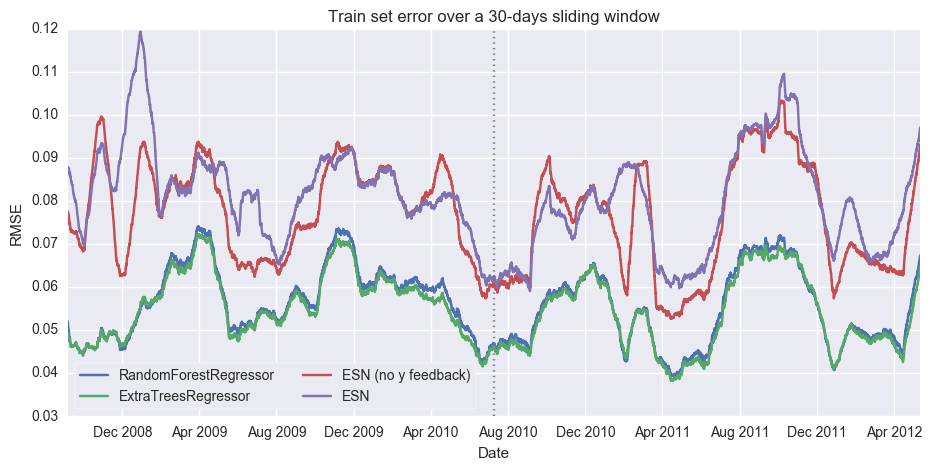

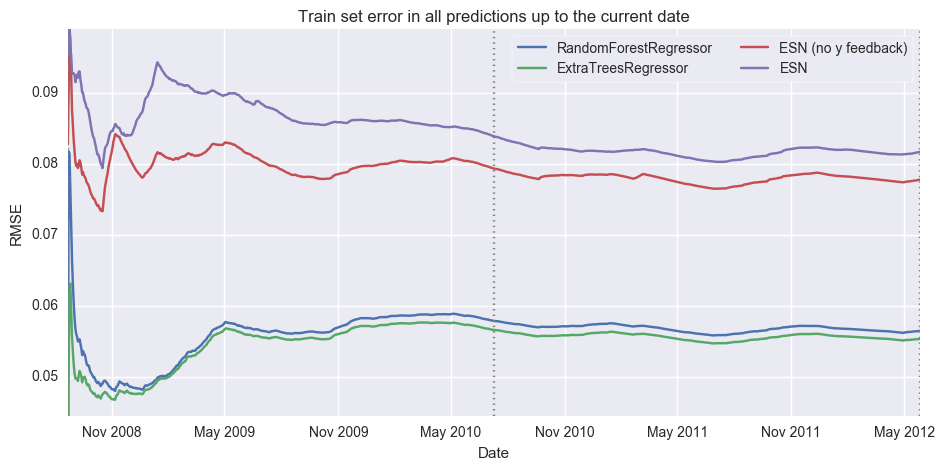

In [117]:
show_error_evolution([
    (rf_err_evol, 'RandomForestRegressor'),
    (et_err_evol, 'ExtraTreesRegressor'),
    (esnnf_err_evol, 'ESN (no y feedback)'),
    (esn_err_evol, 'ESN')
    ], 'Train set');

Error over the test set

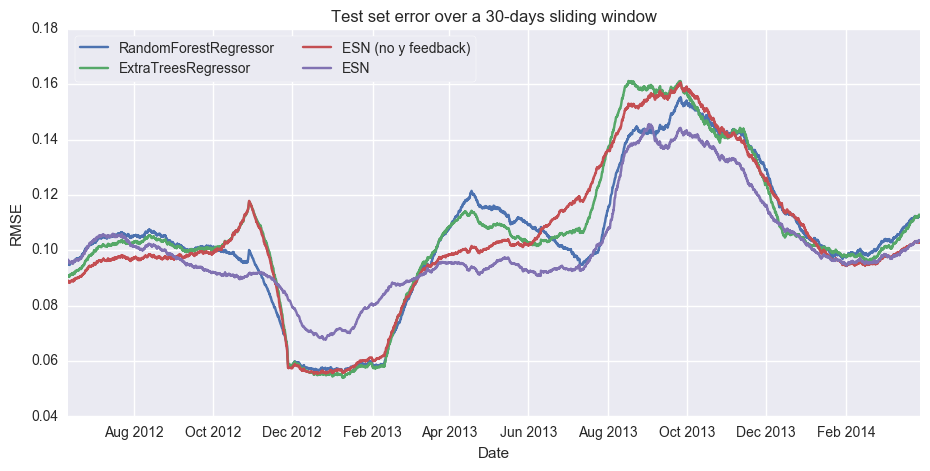

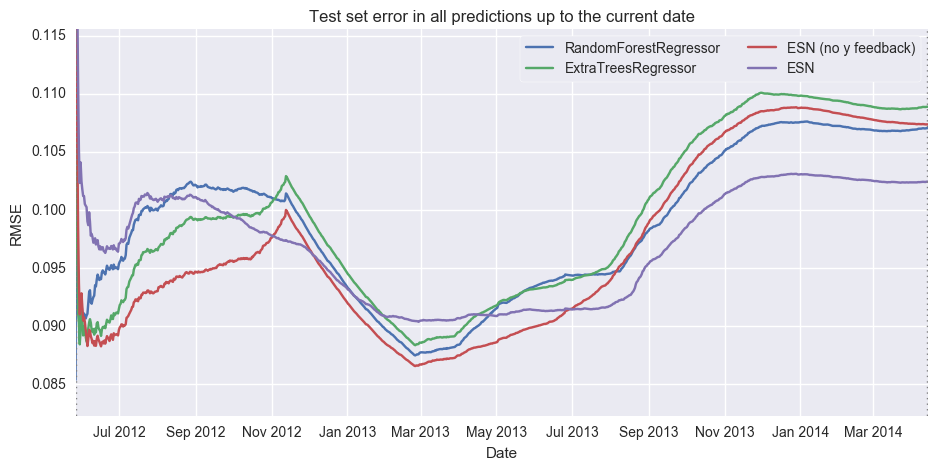

In [118]:
show_error_evolution([
    (rf_err_evol_t, 'RandomForestRegressor'),
    (et_err_evol_t, 'ExtraTreesRegressor'),
    (esnnf_err_evol_t, 'ESN (no y feedback)'),
    (esn_err_evol_t, 'ESN')
    ], 'Test set');

Take these results with a grain of salt, as the ESNs are heavily tuned, whereas the Random Forests aren't. Still, the plots show some interesting behaviours. The model that struggles the most in the train set (ESN with feedback) is the one that ultimately wins in the test set.

---

## Training ensembles

Inspecting the behaviour of ensembled Echo State Networks on the problem.

In total, 51 ESNs are trained. At each step, each of the 51 produces its prediction. Those predictions are aggregated with a median, and the result is fed back to all ESNs at the next step via the output-to-reservoir recurrent connections (if `output_feedback=True` and `feedback_ensemble_y=True`), thus helping to stabilize reservoirs' dynamics.

In [119]:
#y_init = y_mean
y_init = np.zeros(y.shape[1])

In [120]:
rng, seed = initialize_rng(seed=42)
print('Seed:', seed)

model_args = dict(aggregate='median', nr_neurons=500, prob_connect=0.25, spectral_radius=0.99,
                  activation='sigmoid', leaking_rate=0.75, output_feedback=True, y_noise=0.005, alpha=60)
train_args = dict(nr_models=51, y_initial=y_init)
#train_args['weighted'] = True

m = ESN_ensemble(**model_args)
%time m.fit(scale(X), y, **train_args)

Seed: 42
Wall time: 5min 18s


In [130]:
# number of dimensions per layer (input, reservoir, readout) in each of the ensemble's models
print(m.M[0])

570-500-33 ESN


Evaluate error on the test set

In [121]:
# prediction with no ensembled feedback
# (may fail because of some models getting completely off track -- proper regularization (alpha) helps prevent that)
%time yt_p = m.predict(scale(Xt), y_initial=y_init)
RMSE(y_true=yt, y_pred=yt_p)

Wall time: 2min 54s


0.099591205622913306

In [122]:
# with ensembled feedback, test error if ensemble aggregation would use mean
m.aggregate = np.mean
%time yt_p = m.predict(scale(Xt), y_initial=y_init, feedback_ensemble_y=True)
RMSE(y_true=yt, y_pred=yt_p)

Wall time: 4min 38s


0.09957891584445154

In [123]:
# with ensembled feedback, test error if ensemble aggregation would use median
m.aggregate = np.median
%time yt_p = m.predict(scale(Xt), y_initial=y_init, feedback_ensemble_y=True)
RMSE(y_true=yt, y_pred=yt_p)

Wall time: 4min 46s


0.099512163776447879

Advance ESNs through the train set. Then, while preserving the final reservoirs' states (`r`), and supplying the true `y(t-1)`, predict evolution on the test set. The test set starts right where the train set leaves off (1h apart), so the reservoirs' states can be carried over.

In [124]:
%time y_p = m.predict(scale(X), y_initial=y_init, feedback_ensemble_y=True)
print('Train set error:', RMSE(y_true=y, y_pred=y_p))
%time yt_p = m.predict(scale(Xt), reset_r=False, y_initial=y[-1], feedback_ensemble_y=True)
RMSE(y_true=yt, y_pred=yt_p)

Wall time: 9min 47s
Train set error: 0.0779623050023
Wall time: 5min 1s


0.099483520363357461

Collect data for the "error over time" plots.

In [125]:
esn_ensemb_err_evol = error_evolution(y, y_p, X_date)
esn_ensemb_err_evol_t = error_evolution(yt, yt_p, Xt_date)
# summary of the test set error
error_evolution_summary(esn_ensemb_err_evol_t)

(0.099483520363357461,
 rmse(range=[0.065581192907084015, 0.1415317478968387], period='per_month'),
 rmse(range=[0.059035950615868076, 0.10866466174433767], period='so_far'))

How does the ensemble's aggregate error change as more and more models are trained and added to the ensemble?

To reduce computation time in this analysis, given that `feedback_ensemble_y=True`, each model is made to predict the next `y` state while being fed in `y_prev` the ground truth (assumes the ensemble had obtained perfect prediction at the previous time step). That's the reason why these error values are lower than seen above.

Wall time: 7min 8s


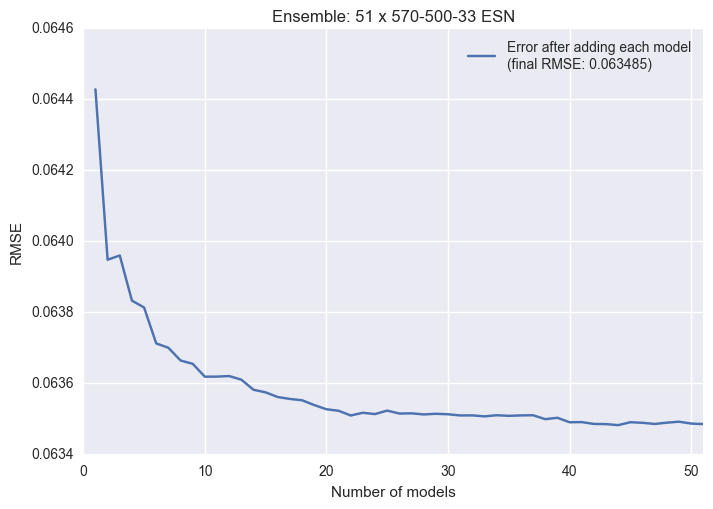

In [126]:
# error change in the train set
%time e = m.error(scale(X), y, y_initial=y_init, feedback_ensemble_y=True)
m.show_error(e)
plt.savefig('plots/error_over_nrmodels__trainset.png');

Wall time: 3min 40s


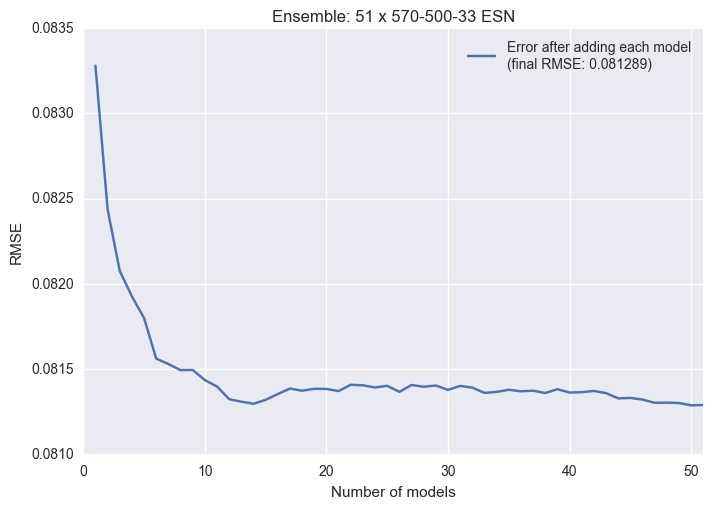

In [127]:
# error change in the test set
%time et = m.error(scale(Xt), yt, y_initial=y_init, feedback_ensemble_y=True)
m.show_error(et)
plt.savefig('plots/error_over_nrmodels__testset.png');

Error over the train set

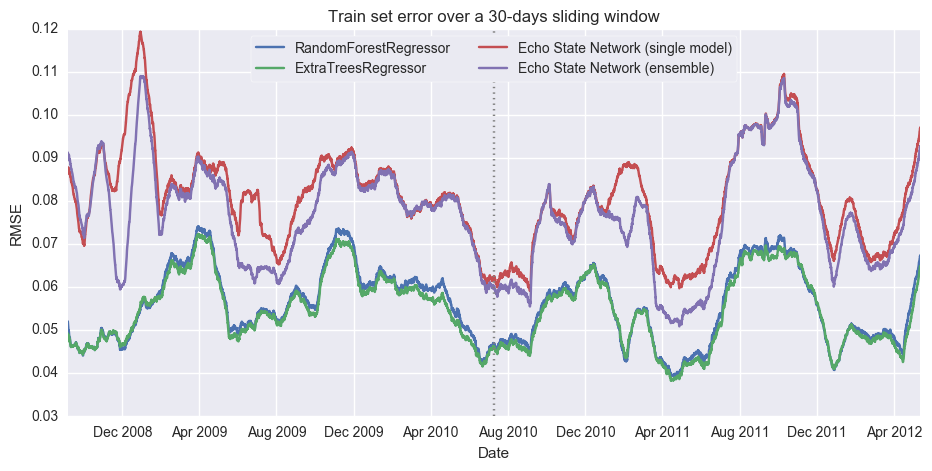

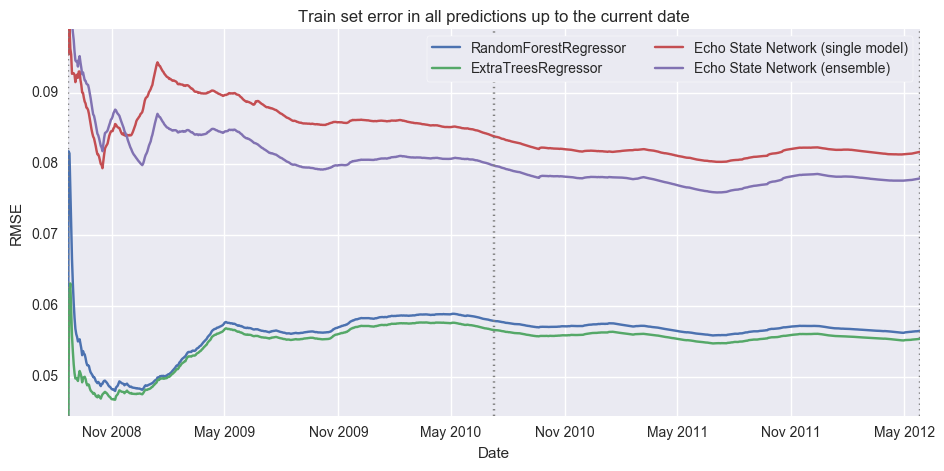

In [128]:
fig1, fig2 = show_error_evolution([
    (rf_err_evol, 'RandomForestRegressor'),
    (et_err_evol, 'ExtraTreesRegressor'),
    (esn_err_evol, 'Echo State Network (single model)'), # using y feedback
    (esn_ensemb_err_evol, 'Echo State Network (ensemble)'),
    ], 'Train set')

fig1.savefig('plots/error_over_time__trainset__per_month.png')
fig2.savefig('plots/error_over_time__trainset__so_far.png');

Error over the test set

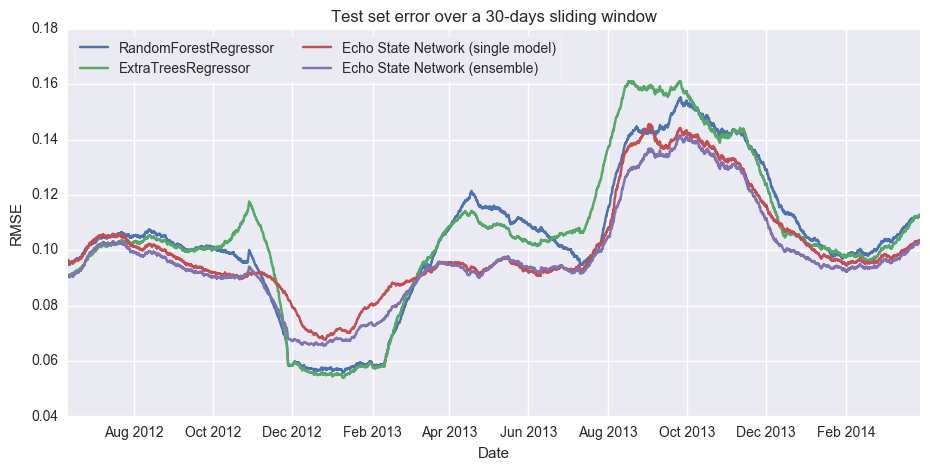

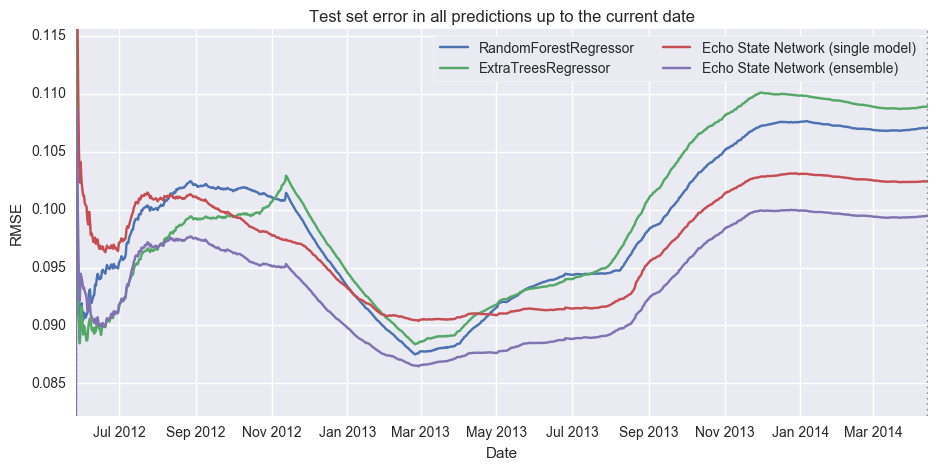

In [129]:
fig1, fig2 = show_error_evolution([
    (rf_err_evol_t, 'RandomForestRegressor'),
    (et_err_evol_t, 'ExtraTreesRegressor'),
    (esn_err_evol_t, 'Echo State Network (single model)'), # using y feedback
    (esn_ensemb_err_evol_t, 'Echo State Network (ensemble)'),
    ], 'Test set')

fig1.savefig('plots/error_over_time__testset__per_month.png')
fig2.savefig('plots/error_over_time__testset__so_far.png');

---

# Preparing submission

Define train & test sets (respectively: full training data, and data to be predicted)

In [72]:
_X, _y = X_train.as_matrix(), Y_train.as_matrix()
_Xt, _yt = X_test.as_matrix(), Y_test.as_matrix()

Determine the mean y in the full train set

In [73]:
y_mean_tr = _y.mean(axis=0)

The code below regenerates my final (and best) submission to the competition (Leaderboard RMSE: `0.089078627464354`; Final results RMSE: `0.088395630359812905`).

The parameter settings below are those I was using at the time. See [above](#Comparison-against-parameters-of-the-final-submission) the performance comparison against the parameter settings tuned after the end of the competition.

Train ensemble

In [74]:
rng, seed = initialize_rng(seed=20120617)

model_args = dict(aggregate='median', nr_neurons=400, prob_connect=0.75, spectral_radius=0.95,
                  activation='sigmoid', leaking_rate=1.0, output_feedback=True, y_noise=0.1, alpha=30)
train_args = dict(nr_models=61, y_initial=y_mean_tr)

m = ESN_ensemble(random_state=rng, **model_args)
%time m.fit(scale(_X), _y, **train_args)

Wall time: 7min 45s


In [75]:
# number of dimensions per layer (input, reservoir, readout) in each of the ensemble's models
print(m.M[0])

470-400-33 ESN


Advance ESNs through the train set. Then, while preserving the final reservoirs' states (`r`), and supplying the true `y(t-1)`, predict evolution on the test set. The test set starts right where the train set leaves off (1h apart), so the reservoirs' states can be carried over.

In [76]:
%time y_p = m.predict(scale(_X), y_initial=y_mean_tr, feedback_ensemble_y=True)
print('Train set error:', RMSE(y_true=_y, y_pred=y_p))
%time yt_p = m.predict(scale(_Xt), reset_r=False, y_initial=_y[-1], feedback_ensemble_y=True)

Wall time: 13min 39s
Train set error: 0.082120002377
Wall time: 4min 34s


In [77]:
# collect data for the "error over time" plots
esn_ensemb_trerr_evol = error_evolution(_y, y_p, dates=X_train.index)
error_evolution_summary(esn_ensemb_trerr_evol)

(0.082120002377028975,
 rmse(range=[0.05250875677133602, 0.13277213980636293], period='per_month'),
 rmse(range=[0.082015117767158738, 0.13259536514289058], period='so_far'))

Error over the train set

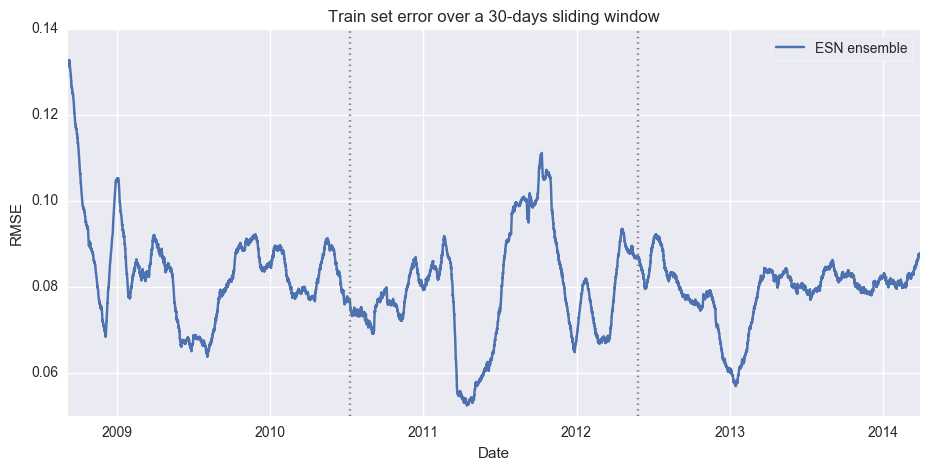

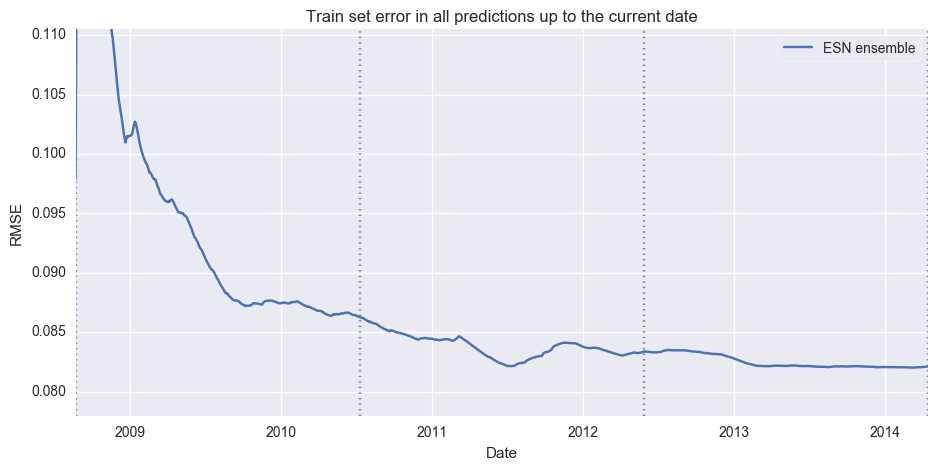

In [88]:
fig1, fig2 = show_error_evolution([
    (esn_ensemb_trerr_evol, 'ESN ensemble'),
    ], 'Train set')

fig1.savefig('plots/error_over_time__fulltrainset__per_month.png')
fig2.savefig('plots/error_over_time__fulltrainset__so_far.png');

How does the ensemble's aggregate error change as more and more models are trained and added to the ensemble?

To reduce computation time in this analysis, given that `feedback_ensemble_y=True`, each model is made to predict the next `y` state while being fed in `y_prev` the ground truth (assumes the ensemble had obtained perfect prediction at the previous time step). That's the reason why these error values are lower than seen above.

Wall time: 11min 49s


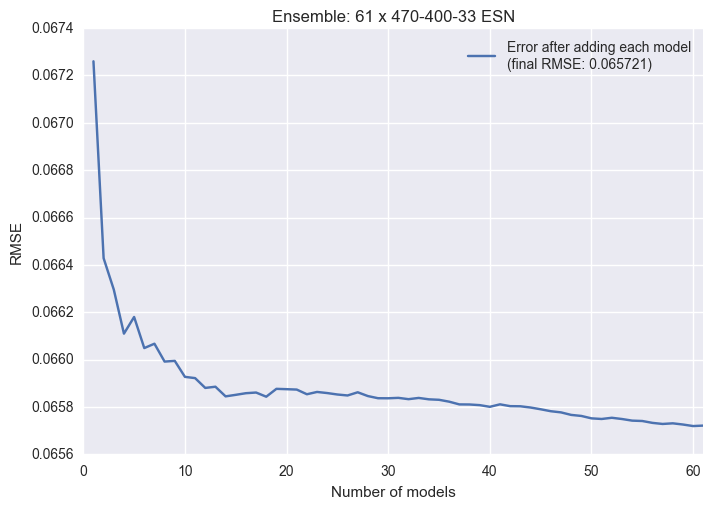

In [79]:
# error change in the train set
%time e = m.error(scale(_X), _y, y_initial=y_mean_tr, feedback_ensemble_y=True)
m.show_error(e)
plt.savefig('plots/error_over_nrmodels__fulltrainset.png');

## Writting submission file

In [80]:
PREDICTON = yt_p

In [81]:
#Converting the prediction matrix to a dataframe
Y_test_hat = pd.DataFrame(PREDICTON, index=X_test.index, columns=power_cols)

In [82]:
# We need to convert the parsed datetime back to utc timestamp
#Y_test_hat['ut_ms'] = (Y_test_hat.index.astype(np.int64) * 1e-6).astype(int)
Y_test_hat['ut_ms'] = list(map(int, Y_test_hat.index.astype(np.int64) * 1e-6))

In [83]:
# Writing the submission file as csv
Y_test_hat[['ut_ms'] + power_cols].to_csv('lfs_submission_5b__rebuilt.csv', index=False)

In [84]:
#Y_test_hat

In [85]:
Y_test_hat.describe()

,NPWD2372,NPWD2401,NPWD2402,NPWD2451,NPWD2471,NPWD2472,NPWD2481,NPWD2482,NPWD2491,NPWD2501,...,NPWD2801,NPWD2802,NPWD2821,NPWD2851,NPWD2852,NPWD2871,NPWD2872,NPWD2881,NPWD2882,ut_ms
count,16488.000000,16488.000000,16488.000000,16488.000000,16488.000000,16488.000000,16488.000000,16488.000000,16488.000000,16488.000000,...,16488.000000,16488.000000,16488.000000,16488.000000,16488.000000,16488.000000,16488.000000,16488.000000,16488.000000,1.648800e+04
mean,0.130161,0.001511,0.175428,0.793669,0.000739,0.001462,0.003887,0.001885,0.210047,0.005308,...,0.001539,0.128088,0.005789,0.332270,0.000530,0.000522,0.000746,0.042074,0.003377,1.427110e+12
std,0.024865,0.001799,0.000167,0.283946,0.000002,0.000277,0.006839,0.001646,0.035074,0.000973,...,0.000005,0.049861,0.000019,0.132968,0.000005,0.000002,0.000003,0.036213,0.000012,1.713535e+10
min,0.050567,-0.002940,0.173821,0.142760,0.000733,0.000641,-0.010676,-0.002175,0.081754,0.003165,...,0.001524,-0.003997,0.005740,0.001895,0.000519,0.000518,0.000739,-0.067275,0.003346,1.397434e+12
25%,0.112177,0.000252,0.175360,0.566974,0.000737,0.001295,-0.000168,0.000724,0.187719,0.004710,...,0.001536,0.089180,0.005777,0.224831,0.000526,0.000521,0.000744,0.017079,0.003369,1.412272e+12
50%,0.131840,0.001114,0.175441,0.823719,0.000738,0.001469,0.001650,0.001523,0.210234,0.005117,...,0.001539,0.123745,0.005788,0.362267,0.000529,0.000522,0.000745,0.043874,0.003374,1.427110e+12
75%,0.148991,0.002411,0.175526,1.023698,0.000740,0.001658,0.006564,0.002751,0.234179,0.005673,...,0.001543,0.167554,0.005799,0.438133,0.000532,0.000523,0.000747,0.067589,0.003383,1.441948e+12
max,0.211658,0.007937,0.175938,1.349354,0.000746,0.002365,0.055659,0.007996,0.331272,0.012590,...,0.001554,0.288876,0.005840,0.633178,0.000578,0.000526,0.000753,0.163962,0.003409,1.456787e+12


---